Lecture notes

- Sample size: n
- Predictor dim: p
- Parameter #: d

1. Feature selection
- Best subset selection
    - Evaluate for all k=0...p predictors cases
    - Not practical for large p
- Stepwise selection
    - Forward: add predictor 1by1 to meet the threshold
    - Backword: remove predictor 1by1 to meet the threshold; only valid for n>p
    - Hybrid
    - Not guaranteed to yield the best model
- Choose the optimal model
    - Cp, AIC, BIC: depend on n, d, RSS and the estimate of the variance of epsi
    - Adjusted R^2: depends on RSS, TSS, n, and d
    - Validation and CV (estimate the test error without estimating the variance of epsi)
        - One-standard-error rule
        - Note: must partition the whole sample first before selecting predictors

2. Shrinkage methods
- Ridge regression
    - tuning parameter: lambda
    - minimize (RSS + l2 shrinkage penalty)
    - shrinkage penalty controls the Var(f)
    - better standardizing the predictor first
- Lasso
    - Use l1 norm in shrinkage penalty
    - Note: for sufficiently lage lambda, beta could be exact zero, which is like performing a predictor selection
- Determine tuning parameter
    - Compute CV error for each lambda and choose the one with the smallest error
    - Use the selected lambda to re-fit the model with the full sample
    
3. Dimension reduction methods
- Transform the p predictors to M predictors (components), where M is less than p
- Principle component analysis (PCA)
    - Only use X, not include Y, to determine components
- Partial least square (PLS)
    - Use both X and Y to determine components
- Use CV to determine the number of components
- Note: PCA/PLS is not predictor selection, as all predictors are used for getting each component    

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, DataFrame, DataFrameReader
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorSlicer, StandardScaler, PCA
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.classification import LogisticRegression
import itertools
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml import Pipeline

%matplotlib inline

# change the path on your machine
findspark.init("/Users/lhd0430/Downloads/spark")

In [2]:
# Creat spark session
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

In [52]:
# Load data as pyspark.sql.DataFrame
data = spark.read.csv("../data/Hitters.csv", header=True, inferSchema=True)
data.cache()
print(data.count())
data = data.dropna()
print(data.count())

322
322


In [53]:
# Convert string to index
data = data.withColumn("Salary",data.Salary.cast(DoubleType()))
data = data.dropna()
catColumns = ["League","Division","NewLeague"]
for i in catColumns:
    indexer = StringIndexer(inputCol=i, outputCol=i+"Indexed")
    model = indexer.fit(data)
    data = model.transform(data)
    data = data.drop(i)
data.show(5)

In [74]:
# Convert feature to vector type
featureCol = data.columns
featureCol.remove('Salary')
vecAssembler = VectorAssembler(inputCols=featureCol, outputCol="features")
df = vecAssembler.transform(data)
df.show(5)

+-----+----+-----+----+---+-----+-----+------+-----+------+-----+----+------+-------+-------+------+------+-------------+---------------+----------------+--------------------+
|AtBat|Hits|HmRun|Runs|RBI|Walks|Years|CAtBat|CHits|CHmRun|CRuns|CRBI|CWalks|PutOuts|Assists|Errors|Salary|LeagueIndexed|DivisionIndexed|NewLeagueIndexed|            features|
+-----+----+-----+----+---+-----+-----+------+-----+------+-----+----+------+-------+-------+------+------+-------------+---------------+----------------+--------------------+
|  315|  81|    7|  24| 38|   39|   14|  3449|  835|    69|  321| 414|   375|    632|     43|    10| 475.0|          1.0|            0.0|             1.0|[315.0,81.0,7.0,2...|
|  479| 130|   18|  66| 72|   76|    3|  1624|  457|    63|  224| 266|   263|    880|     82|    14| 480.0|          0.0|            0.0|             0.0|[479.0,130.0,18.0...|
|  496| 141|   20|  65| 78|   37|   11|  5628| 1575|   225|  828| 838|   354|    200|     11|     3| 500.0|          1.0

In [100]:
# Scale data
scaler = StandardScaler(inputCol="features", outputCol="scaledfeatures",
                        withStd=True, withMean=False)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)
df.show(5)

+-----+----+-----+----+---+-----+-----+------+-----+------+-----+----+------+-------+-------+------+-------+-------------+---------------+----------------+--------------------+--------------------+
|AtBat|Hits|HmRun|Runs|RBI|Walks|Years|CAtBat|CHits|CHmRun|CRuns|CRBI|CWalks|PutOuts|Assists|Errors| Salary|LeagueIndexed|DivisionIndexed|NewLeagueIndexed|            features|      scaledfeatures|
+-----+----+-----+----+---+-----+-----+------+-----+------+-----+----+------+-------+-------+------+-------+-------------+---------------+----------------+--------------------+--------------------+
|  315|  81|    7|  24| 38|   39|   14|  3449|  835|    69|  321| 414|   375|    632|     43|    10|  475.0|          1.0|            0.0|             1.0|[315.0,81.0,7.0,2...|[2.13838822048095...|
|  479| 130|   18|  66| 72|   76|    3|  1624|  457|    63|  224| 266|   263|    880|     82|    14|  480.0|          0.0|            0.0|             0.0|[479.0,130.0,18.0...|[3.25170780193770...|
|  496| 14

In [104]:
# Feature selection
evaMSE = RegressionEvaluator(labelCol="Salary",metricName="mse")

def processSubset(feature_set):
    slicer = VectorSlicer(inputCol="scaledfeatures", outputCol="slicedfeatures", indices=list(feature_set))
    sliceddf = slicer.transform(df)
    lr = LinearRegression(featuresCol="slicedfeatures", labelCol="Salary")
    ml = lr.fit(sliceddf)
    predict = ml.transform(sliceddf)
    mse = evaMSE.evaluate(predict)
    return {"Model":ml,"MSE":mse}

In [114]:
# Best subset selection
def getBest(k):
    results = []
    for combo in itertools.combinations(range(0,len(featureCol)),k):
        results.append(processSubset(combo))
    models = pd.DataFrame(results)
    best_model = models.iloc[models['MSE'].argmin()]
    return best_model

models_best = pd.DataFrame(columns=["Model","MSE"])

for i in range(2,3):
    models_best.loc[i] = getBest(i)

print(models_best.MSE.argmin()) 

plt.figure
plt.plot(np.arange(2,3),models_best.MSE)
plt.show()

2


19


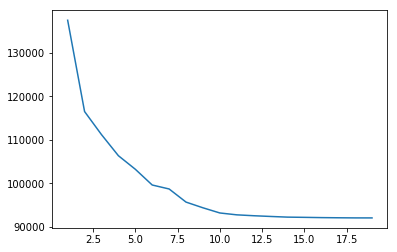

In [118]:
# Forward selection
def forward(predictors):
    results = []
    remain_predictors = [p for p in range(len(featureCol)) if p not in predictors]
    for p in remain_predictors:
        results.append(processSubset(predictors+[p]))
    models = pd.DataFrame(results)
    best_model = models.iloc[models['MSE'].argmin()]
    best_p = remain_predictors[models['MSE'].argmin()]
    return best_model, predictors+[best_p]

models_fwd = pd.DataFrame(columns=["Model","MSE"])
predictors = []
for i in range(1,len(featureCol)+1):
    models_fwd.loc[i], predictors= forward(predictors)
    
print(models_fwd.MSE.argmin())    
plt.figure()
plt.plot(models_fwd.MSE)
plt.show()

18


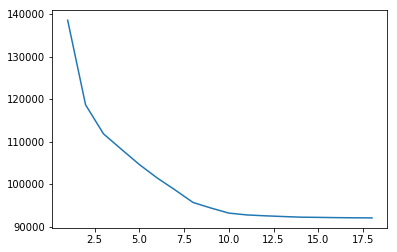

In [119]:
# Backward selection
def backward(predictors):
    results = []
    new_predictors = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
        new_predictors.append(combo)
    models = pd.DataFrame(results)
    best_model = models.iloc[models['MSE'].argmin()]
    best_ps = new_predictors[models['MSE'].argmin()]
    return best_model, best_ps

models_bwd = pd.DataFrame(columns=["Model","MSE"])
predictors = range(len(featureCol))
while(len(predictors)>1):
    models_bwd.loc[len(predictors)-1], predictors= backward(predictors)
    
print(models_bwd.MSE.argmin())    
fig,ax = plt.subplots(1,1)
plt.plot(models_bwd.MSE)
plt.show()


9


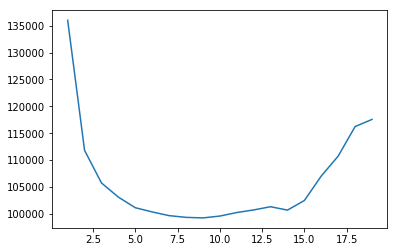

In [217]:
# CV to find the best num of features

def processSubsetCV(feature_set, trainfolds, testfolds):
    slicer = VectorSlicer(inputCol="scaledfeatures", outputCol="slicedfeatures", indices=list(feature_set))
    sliceddf = slicer.transform(df)
    train = sliceddf.filter(trainfolds)
    test = sliceddf.filter(testfolds)
    lr = LinearRegression(featuresCol="slicedfeatures", labelCol="Salary")
    ml = lr.fit(train)
    predict = ml.transform(test)
    mse = evaMSE.evaluate(predict)
    return {"Model":ml,"MSE":mse}

def forwardCV(predictors, trainfolds, testfolds):
    results = []
    remain_predictors = [p for p in range(len(featureCol)) if p not in predictors]
    for p in remain_predictors:
        results.append(processSubsetCV(predictors+[p], trainfolds, testfolds))
    models = pd.DataFrame(results)
    best_model = models.iloc[models['MSE'].argmin()]
    best_p = remain_predictors[models['MSE'].argmin()]
    return best_model, predictors+[best_p]

# Create folds
k = 3
foldsize = df.count()/k
df = df.withColumn("id",monotonically_increasing_id())

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(featureCol)+1))
cv_errors = cv_errors.fillna(0)

models_cv = pd.DataFrame(columns=["Model", "MSE"])
    
# Outer loop iterates over all folds
for j in range(1,k+1):

    # Reset predictors
    predictors = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(featureCol)+1):    
    
        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i],predictors = forwardCV(predictors, (df["id"] < (j-1)*foldsize)|(df["id"] > j*foldsize), (df["id"] > (j-1)*foldsize)&(df["id"] < j*foldsize))
        
        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.MSE[i]

cv_mean = cv_errors.mean(axis=1)
print(cv_mean.argmin())

plt.figure()
plt.plot(cv_mean)
plt.show()

# Fit the model again for the best num of features 
model = getBest(9)


203792.83627417978


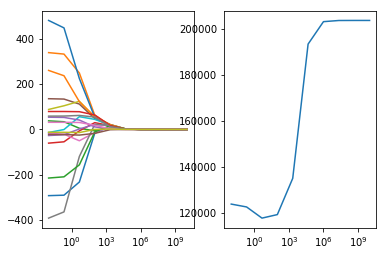

In [239]:
# Ridge
alphas = np.logspace(10,-2,10)
coefs = []
for a in alphas:
    lr = LinearRegression(regParam=a,elasticNetParam=0,featuresCol="scaledfeatures",labelCol="Salary")
    ml = lr.fit(df)
    coefs.append(ml.coefficients)

# CV to determine tuning parameter
alphas = list(np.logspace(10,-2,10))
evaMSE = RegressionEvaluator(labelCol="Salary",metricName="mse")
paramGrid = ParamGridBuilder().addGrid(lr.regParam, alphas).build()
cv = CrossValidator(estimator=lr, evaluator=evaMSE, numFolds=3, estimatorParamMaps=paramGrid)
ml = cv.fit(df)
print(ml.avgMetrics[0])

# Plot
fig, axes = plt.subplots(1,2)
axes[0].plot(alphas,coefs)
axes[0].set_xscale('log')
axes[1].plot(alphas,ml.avgMetrics)
axes[1].set_xscale('log')
plt.show()

In [243]:
# Lasso
# Same as Ridge above, with elasticParam = 1.0

4


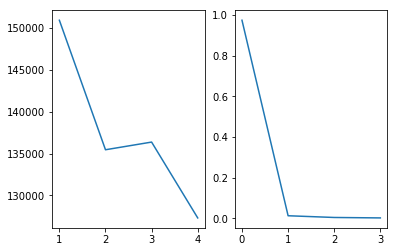

In [304]:
# PCA

pca = PCA(k=3, inputCol="features", outputCol="pcafeatures")
model = pca.fit(df)
result = model.transform(df)

# CV with pipeline to determine best k
# build pipeline
k = list(range(1,5))
pca = PCA(inputCol="features", outputCol="pcafeatures")
lr = LinearRegression(featuresCol="pcafeatures", labelCol="Salary")
pipeline = Pipeline(stages=[pca, lr])
# CV
evaMSE = RegressionEvaluator(labelCol="Salary",metricName="mse")
paramGrid = ParamGridBuilder().addGrid(pca.k, k).build()
cv = CrossValidator(estimator=pipeline, evaluator=evaMSE, numFolds=3, estimatorParamMaps=paramGrid)
ml = cv.fit(df)
bestpca = ml.bestModel.stages[0]
bestk = list(bestpca.extractParamMap().values())[2]
print(bestk)

# Plot
fig, axes = plt.subplots(1,2)
axes[0].plot(np.array(k),ml.avgMetrics)
axes[1].plot(bestpca.explainedVariance)
plt.show()


In [305]:
# PLS
# not available in pyspark

In [306]:
spark.stop()